## Task 1

### Binary numbers

In this exercise, the inputs are positive integers so we define an assertions 
function which verifies that.

In [1]:
def assertions(num:int) -> None:
    '''
    Input: num 
    This function asserts whether the input num is a positive integer
    '''
    assert isinstance(num,int), "Input to binary_digit_sum should be int"
    assert num > 0, "Input integer should be positive"

The first function returns the sum of digits of a number when it is written in binary. We run this function for num=12.

In [3]:
def binary_digit_sum(num: int) -> int:
    ''' 
    Input: num 
    Output: sum of digits of num in binary. 
    Example: num = 12 (base 10) = 1100 (base 2) => output 1+1+0+0 = 2
    '''
    assertions(num)
    res = 0
    while num:  num, res = num//2, res + num%2
    return res

In [5]:
num = 12
print("The binary digit sum of {} is {}.".format(num,binary_digit_sum(num)))

The binary digit sum of 12 is 2.


We now write the binary representation of a number (given in base 10) as a list.

In [6]:
def binary_array(num: int) -> list[str]:
    '''
    Input: num 
    Output: list of digits of num in binary.
    Example: num = 12 (base 10) = 1100 (base 2) => output ['1', '1', '0', '0']
    '''
    assertions(num)
    return list(bin(num)[2:])

In [7]:
print("The binary array representation of {} is {}.".format(num,binary_array(num)))

The binary array representation of 12 is ['1', '1', '0', '0'].


### Groups of people

We now write a function that computes the number of ways we can split a group of people in two.

In [10]:
from math import comb
def num_comb_group_in_half(k: int) -> int:
    '''
    There are 2k people in a group, k>0. 
    Output: Number of ways of spliting the group to two equally sized groups of k people.
    '''
    assertions(k)
    # There are n choose m ways to split a group of n people into groups of m and n-m. 
    # Hence our answer is 2k choose k.
    return comb(2*k,k)

In [11]:
k = 2
print("There are {} ways of splitting a group of {} people in groups of {}.".format(
    num_comb_group_in_half(k), 2* k, k
))

There are 6 ways of splitting a group of 4 people in groups of 2.


Finally we write a function that returns the possible combinations of half-groups that can be formed from the original group.

In [12]:
from itertools import combinations
from typing import Set
def pairs_group_in_half(k: int) -> list[list[Set[int]]]:
    '''
    There are 2k people in a group, k>0. 
    Output: List of all possible pairs 
    Example: for k=1=> 2 people the list of possible pairs is 
    [ [ {0}, {1}], [{1} , {0}] ]
    '''
    assertions(k)
    assert k <= 10, "Splitting a group of more than 20 people results in more than 7*10^5 pairs! Decrease k."
    group = set(range(2*k))
    return [[ set(c) , group - set(c) ] for c in  combinations(range(2*k),k)]

In [13]:
print("Those pairs are {}".format(pairs_group_in_half(k)))

Those pairs are [[{0, 1}, {2, 3}], [{0, 2}, {1, 3}], [{0, 3}, {1, 2}], [{1, 2}, {0, 3}], [{1, 3}, {0, 2}], [{2, 3}, {0, 1}]]


# Stable Marriage Problem

In [15]:
import random
from collections.abc import Sequence
from tabulate import tabulate
from typing import Iterable, Dict, List, Sequence, Any, Tuple

## Task 2

In [114]:
Sym: Any = int | str

In [57]:
class Table(dict):
    '''
    This class represents the preference tables that are used in the 
    Stable Matching Problem. 
    '''
    def __init__(self, table: Any):
        super().__init__(table)
        self.validator()
        
    def validator(self) -> None:
        assert self.right_type(), 'Input does not have right type'
        assert self.consistent_dimension(), 'Input table has preference lists of different length'
        assert self.no_duplicates(), 'Input has duplicate values in a preference list.'
    
    def right_type(self) -> bool:
        '''Assesses whether table is of the right type'''
        return isinstance(self,dict) and  \
                all(isinstance(x, Sequence) for x in self.values()) and \
                all(all(isinstance(y, Sym.__args__) for y in x) for x in self.values())
    
    def consistent_dimension(self) -> bool: 
        '''Assesses whether the table preference lists have consistent dimensions'''
        n: int = len(self[next(iter(self))])
        return all(len(x) == n for x in self.values())
        
    def no_duplicates(self) -> bool:
        '''Checks whether preference lists contain any duplicates'''
        return all(len(pref_list) == len(set(pref_list))  for pref_list in self.values())

In [58]:
class Table(Table):
    def get_rank(self) -> None: 
        '''
        Creates a version of the table where the preference lists (values of the dictionary) are inverted.
        A preference list ["a","b","c"] becomes a ranking dictionary {"a":1,"b":2,"c":3} 
        so that output[X][y] is the ranking of y according to X.
        Rankings begin from zero.
        '''
        self.rank = {key: {v:i for i,v in enumerate(val)} | {None:len(val)}  for key,val in self.items()}
    def __repr__(self) -> str:
        '''
        Tables are printed using the tabulate library for pretty visualization
        '''
        n: int = len(self)
        matrix: List[List[Sym]] = [[k] + list(v) for k, v in self.items()]
        ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
        headers: List[str] = [""] + [ordinal(i) for i in range(1,n+1)]
        return str(tabulate(matrix,tablefmt="fancy_grid",headers=headers))

In [59]:
# This example is given in Ch1 and Ch2 of 
# Stable Marriage and Its Relation to Other Combinatorial Problems.
p1: Table = Table({'A': ['c', 'b', 'd', 'a'], 'B': ['b', 'a', 'c', 'd'], \
        'C': ['b', 'd', 'a', 'c'], 'D': ['c', 'a', 'd', 'b']})
a1: Table =  Table({'a': ['A', 'B', 'D', 'C'], 'b': ['C', 'A', 'D', 'B'], \
        'c': ['C', 'B', 'D', 'A'], 'd': ['B', 'A', 'C', 'D']})
print("Proposer table")
print(p1)
print("Acceptor Table")
print(a1)

Proposer table
╒════╤═══════╤═══════╤═══════╤═══════╕
│    │ 1st   │ 2nd   │ 3rd   │ 4th   │
╞════╪═══════╪═══════╪═══════╪═══════╡
│ A  │ c     │ b     │ d     │ a     │
├────┼───────┼───────┼───────┼───────┤
│ B  │ b     │ a     │ c     │ d     │
├────┼───────┼───────┼───────┼───────┤
│ C  │ b     │ d     │ a     │ c     │
├────┼───────┼───────┼───────┼───────┤
│ D  │ c     │ a     │ d     │ b     │
╘════╧═══════╧═══════╧═══════╧═══════╛
Acceptor Table
╒════╤═══════╤═══════╤═══════╤═══════╕
│    │ 1st   │ 2nd   │ 3rd   │ 4th   │
╞════╪═══════╪═══════╪═══════╪═══════╡
│ a  │ A     │ B     │ D     │ C     │
├────┼───────┼───────┼───────┼───────┤
│ b  │ C     │ A     │ D     │ B     │
├────┼───────┼───────┼───────┼───────┤
│ c  │ C     │ B     │ D     │ A     │
├────┼───────┼───────┼───────┼───────┤
│ d  │ B     │ A     │ C     │ D     │
╘════╧═══════╧═══════╧═══════╧═══════╛


## Task 3

In [60]:
class Random_Table(Table): 
    def __init__(self,n: int) -> None:
        table: Dict[int,Sequence[int]] = self.generate_random_table(n)
        super().__init__(table)

    def generate_random_table(self,n: int) -> Dict[Sym,Sequence[Sym]]:
        return {i:random.sample(range(n) ,n) for i in range(n)} 

In [61]:
random.seed(1)
p2: Table = Random_Table(n=5)
a2: Table = Random_Table(n=5)
print("Proposer table")
print(p2)
print("Acceptor Table")
print(a2)

Proposer table
╒════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│    │   1st │   2nd │   3rd │   4th │   5th │
╞════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│  0 │     1 │     0 │     4 │     3 │     2 │
├────┼───────┼───────┼───────┼───────┼───────┤
│  1 │     3 │     4 │     2 │     1 │     0 │
├────┼───────┼───────┼───────┼───────┼───────┤
│  2 │     0 │     3 │     4 │     1 │     2 │
├────┼───────┼───────┼───────┼───────┼───────┤
│  3 │     4 │     0 │     2 │     1 │     3 │
├────┼───────┼───────┼───────┼───────┼───────┤
│  4 │     1 │     0 │     4 │     3 │     2 │
╘════╧═══════╧═══════╧═══════╧═══════╧═══════╛
Acceptor Table
╒════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│    │   1st │   2nd │   3rd │   4th │   5th │
╞════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│  0 │     0 │     4 │     1 │     3 │     2 │
├────┼───────┼───────┼───────┼───────┼───────┤
│  1 │     0 │     1 │     3 │     2 │     4 │
├────┼───────┼───────┼───────┼───────┼───────┤
│  2 │     2 │     1 │     4 │

## Task 4

In [62]:
class Stable_Matching:
    ''' 
    This class solves the Stable Matching Problem.
    It takes two preference tables (proposer,acceptor) with preference lists as values. 
    '''
    def __init__(self, proposer: Table, 
                       acceptor: Table) -> None:  
        assert isinstance(proposer,Table), 'Proposer is not a Table'   
        assert isinstance(acceptor,Table), 'Acceptor is not a Table' 
        for t in (proposer,acceptor):   t.get_rank()
        self.proposer: Table = proposer 
        self.acceptor: Table = acceptor
        assert self.validate_tables_share_symbols(), 'Symbol mismatch between proposer and acceptor'

    def validate_tables_share_symbols(self) -> bool:
        '''
        Validates that the tables share the same symbols in that for every
        preference list of a table there is a 1-1 mapping to the keys of the other table
        '''
        vals2_in_keys1: bool  =  all( set(x) == set(self.proposer.keys()) for x in self.acceptor.values() )
        vals1_in_keys2: bool  =  all( set(x) == set(self.acceptor.keys()) for x in self.proposer.values() )
        return vals1_in_keys2 and vals2_in_keys1

## Task 5

In [63]:
class Stable_Matching(Stable_Matching):
    def matching_is_stable(self, matching: Dict[Sym,Sym]) -> bool:
        '''
        For a given matching (which is a dictionary with key=proposer and value=matched_acceptor)
        the algorithm checks whether the matching is stable returning True if it is.
        '''
        acc: Sym   #Acceptor
        prop: Sym  #Proposer
        props: Iterable[Sym] 
        for acc, props in self.acceptor.items():
            for prop in props:
                if acc == matching[prop]:  break
                curr_acc: Sym = matching[prop]
                if self.proposer.rank[prop][acc] < self.proposer.rank[prop][curr_acc]:   
                    return False
        return True

## Task 6

In [64]:
class Stable_Matching(Stable_Matching):
    def compute_score(self, matching: Dict[Sym,Sym]) -> Tuple[int,int]:
        '''
        Computes the score for proposers and acceptors which is defined as the sum of all the rankings 
        for proposers and acceptors respectively. The higher the score for a group,
        the less the aggregate satisfaction for that group. A score of zero corresponds to complete 
        satisfaction for that group implying that every member of that group got their first preference.
        The highest score is (n-1)*n which corresponds to every member of that group getting their last preference,
        where n is the number of proposers and acceptors.
        '''
        score_proposer: int = sum(self.proposer.rank[prop][matching[prop]] for prop in self.proposer)
        score_acceptor: int = sum(self.acceptor[matching[prop]].index(prop) for prop in self.proposer)
        return score_proposer, score_acceptor

## Task 7

In [65]:
class Stable_Matching(Stable_Matching):
    def solve_problem(self) -> Dict[Sym,Sym]:
        '''
        The Stable Matching Problem is solved using the algorithm descripted in Chapter 2 page 9
        of 'Stable Marriage and Its Relation to Other Combinatorial Problems'.
        A matching (as a dictionary) is returned.
        '''
        prop_individual_score: Dict[Sym,int] = {prop:0 for prop in self.proposer}
        matching: Dict[Sym,Sym|None] = {prop: None for prop in self.proposer}
        inv_matching: Dict[Sym,Sym|None] = {acc: None for acc in self.acceptor}
        prop: Sym|None
        for prop in self.proposer:
            while prop is not None:
                acc: Sym = self.proposer[prop][prop_individual_score[prop]]
                curr_prop: Sym|None = inv_matching[acc]    
                if self.acceptor.rank[acc][prop] < self.acceptor.rank[acc][curr_prop]:
                    matching[prop] = acc
                    prop, inv_matching[acc] = inv_matching[acc], prop
                if prop is not None: prop_individual_score[prop] += 1
        return matching

In [66]:
for proposer, acceptor in [(p1,a1),(p2,a2)]:
    s: Stable_Matching = Stable_Matching(proposer,acceptor)
    opt_matching: Dict[Sym,Sym] = s.solve_problem()
    print(f"Matching found: {opt_matching}")
    print(f"Matching is stable? {s.matching_is_stable(opt_matching)}")
    print(f"Score for (proposers,acceptors) is {s.compute_score(opt_matching)}")
    print("-"*60)

Matching found: {'A': 'd', 'B': 'a', 'C': 'b', 'D': 'c'}
Matching is stable? True
Score for (proposers,acceptors) is (3, 4)
------------------------------------------------------------
Matching found: {0: 1, 1: 4, 2: 3, 3: 2, 4: 0}
Matching is stable? True
Score for (proposers,acceptors) is (5, 8)
------------------------------------------------------------


## Task 8

In [67]:
import time
import matplotlib.pyplot as plt
from numpy import log, exp

In [82]:
def average_execution_time(fun,M=1000,silent=False):
    start = time.perf_counter()
    for _ in range(M): fun()
    end = time.perf_counter()   
    aet = (end-start)/M
    if silent:  return aet
    print(f"Average time of execution for {fun.__name__} is {aet} seconds.")

In [83]:
def given_example():
    proposer: Table = Table({'A': ['c', 'b', 'd', 'a'], 'B': ['b', 'a', 'c', 'd'], \
        'C': ['b', 'd', 'a', 'c'], 'D': ['c', 'a', 'd', 'b']})
    acceptor: Table =  Table({'a': ['A', 'B', 'D', 'C'], 'b': ['C', 'A', 'D', 'B'], \
        'c': ['C', 'B', 'D', 'A'], 'd': ['B', 'A', 'C', 'D']})
    s = Stable_Matching(proposer,acceptor)
    s.solve_problem()

In [84]:
average_execution_time(given_example)

Average time of execution for given_example is 5.829469999298453e-05 seconds.


In [85]:
def random_example(n):
    Stable_Matching(Random_Table(n),Random_Table(n)).solve_problem()

In [86]:
n_vals = list(range(5,101))
aets = list()
for n in n_vals:
    fun = lambda : random_example(n)
    fun.__name__ = f"random_example_n={n}"
    aets.append(average_execution_time(fun,M=20,silent=True))

In [92]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit( log(n_vals).reshape((-1, 1)) ,  log(aets) )
print(f"The coefficient of linear regression is {model.coef_[0]}")

The coefficient of linear regression is 1.7039843720851369


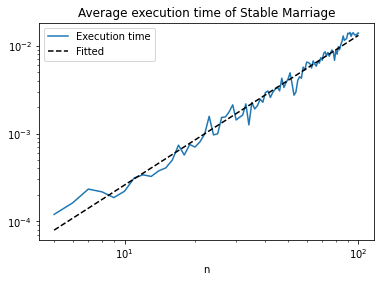

In [95]:
plt.loglog(n_vals,aets)
plt.loglog(n_vals, exp(model.intercept_) * n_vals**model.coef_,\
    color='black', linestyle='dashed')
plt.xlabel(r"n")
plt.title("Average execution time of Stable Marriage")
plt.legend(["Execution time","Fitted"])

## Task 9

In [96]:
from numpy import transpose, linspace

In [102]:
def random_score(n):
    r = Stable_Matching(Random_Table(n), Random_Table(n))
    match = r.solve_problem()
    return r.compute_score(match)

In [103]:
def random_scores(n, M= 1000):
    scores_prop = [None] * M
    scores_acc = [None] * M
    for i in range(M):
        scores_prop[i], scores_acc[i] = random_score(n)
    return scores_prop, scores_acc

In [110]:
def plot_hist(n, **kwargs):
    scores_prop, scores_acc = random_scores(n,**kwargs)
    plt.hist(scores_prop, alpha=0.8)
    plt.hist(scores_acc, alpha=0.8)
    plt.xlabel("Score")
    plt.title(f"Scores for n={n}")
    plt.legend(["Proposer","Acceptor"])

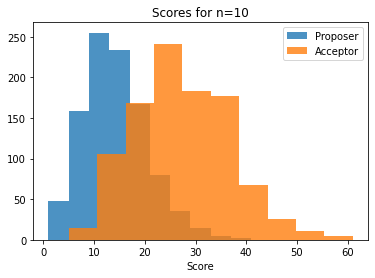

In [111]:
random.seed(1)
plot_hist(10)

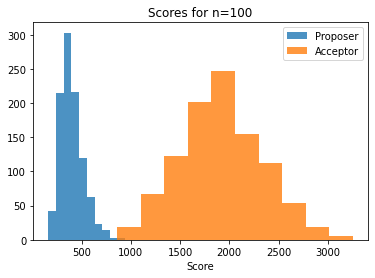

In [112]:
plot_hist(100)

In [113]:
n_vals =  2**linspace(1,10,10)
scores_prop = [None] * len(n_vals)
scores_acc = [None] * len(n_vals)
for i, n in enumerate(n_vals):
    scores_prop[i], scores_acc[i] = random_scores(int(n),M=50)

Text(0.5, 1.0, 'Score whisker plots')

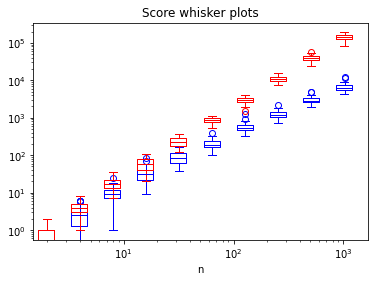

In [116]:
n_vals_str = [str(int(num)) for num in n_vals]
ax = plt.subplot()
for score,c in  [(scores_prop,"blue"), (scores_acc,"red")]:
    ax.boxplot(transpose(score), boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                positions = n_vals,
                widths= n_vals/3
                )
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'n')
ax.set_title('Score whisker plots')

## Task 10